In [ ]:
'Normalized Protein Positions'

In [1]:
import pandas as pd

# Paths
lcs_csv_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Normalized Protein Positions\all_LCS_values.csv"
input_path   = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Normalized Protein Positions\Statistics_Input.xlsx"

# Load data
df_lcs = pd.read_csv(lcs_csv_path)
df_input = pd.read_excel(input_path)

# Merge protein length info into LCS dataframe
df_merged = pd.merge(
    df_lcs,
    df_input[['UniProt_ID', 'Amino_acid_position', 'Protein_length']],
    on=['UniProt_ID', 'Amino_acid_position'],
    how='left'
)

# Calculate normalized position
df_merged['Normalized_Position'] = df_merged['Amino_acid_position'] / df_merged['Protein_length']

# Save back to CSV (overwrite or rename if preferred)
df_merged.to_csv(lcs_csv_path, index=False)


  Quarter  Benign_Count  Pathogenic_Count  Benign_Mean  Pathogenic_Mean  \
0      Q1             3                17     0.112190         0.176661   
1      Q2             8                14     0.061893         0.106796   
2      Q3             4                18     0.087379         0.080007   
3      Q4             3                 7     0.155340         0.101248   

     T_stat   P_value  
0 -2.798366  0.043399  
1 -2.190621  0.063157  
2  0.574835  0.577823  
3  0.947076  0.442214  


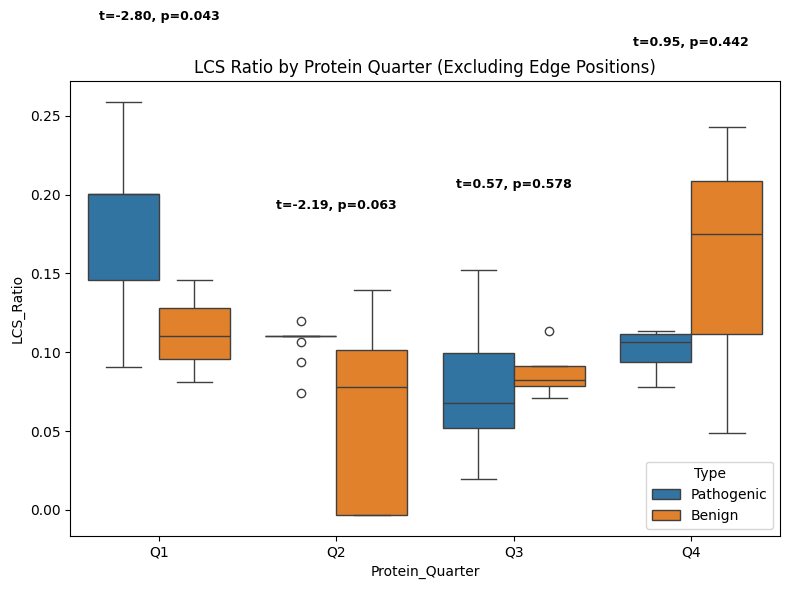

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os

# --- Path to your data file ---
lcs_csv_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Normalized Protein Positions\all_LCS_values.csv"
output_folder = os.path.dirname(lcs_csv_path)

# --- Load data ---
df = pd.read_csv(lcs_csv_path)

# --- Remove outlier heatmap positions ---
outlier_positions = [1, 2, 3, 13, 14, 15]
df_clean = df[~df['Heatmap_Position'].isin(outlier_positions)].copy()
df_clean['Heatmap_Position'] = pd.to_numeric(df_clean['Heatmap_Position'], errors='coerce')

# --- Normalize and bin into quarters ---
df_clean['Normalized_Position'] = (
    df_clean['Heatmap_Position'] - df_clean['Heatmap_Position'].min()
) / (df_clean['Heatmap_Position'].max() - df_clean['Heatmap_Position'].min())

df_clean['Protein_Quarter'] = pd.cut(
    df_clean['Normalized_Position'],
    bins=[0.0, 0.25, 0.5, 0.75, 1.0],
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    include_lowest=True
)

# --- T-tests and annotation data ---
results = []
annotations = {}

for i, quarter in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    subset = df_clean[df_clean['Protein_Quarter'] == quarter]
    benign = subset[subset['Type'].str.lower() == 'benign']['LCS_Ratio']
    pathogenic = subset[subset['Type'].str.lower() == 'pathogenic']['LCS_Ratio']

    if len(benign) > 1 and len(pathogenic) > 1:
        t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)
        text = f"t={t_stat:.2f}, p={p_val:.3f}"
    else:
        t_stat, p_val = np.nan, np.nan
        text = "n/a"

    results.append({
        'Quarter': quarter,
        'Benign_Count': len(benign),
        'Pathogenic_Count': len(pathogenic),
        'Benign_Mean': benign.mean(),
        'Pathogenic_Mean': pathogenic.mean(),
        'T_stat': t_stat,
        'P_value': p_val
    })

    annotations[quarter] = text

# --- Save stats CSV ---
df_stats = pd.DataFrame(results)
stats_csv_path = os.path.join(output_folder, "LCS_stats_by_quarter_filtered.csv")
df_stats.to_csv(stats_csv_path, index=False)

# --- Save printed statistics to text file ---
stats_text_path = os.path.join(output_folder, "LCS_stats_by_quarter_filtered_summary.txt")
with open(stats_text_path, 'w') as f:
    f.write(df_stats.to_string(index=False))

print(df_stats)

# --- Plot with annotations ---
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df_clean, x='Protein_Quarter', y='LCS_Ratio', hue='Type')
plt.title("LCS Ratio by Protein Quarter (Excluding Edge Positions)")

# Add text above each quarter group
group_positions = df_clean['Protein_Quarter'].cat.categories

for i, quarter in enumerate(group_positions):
    y_max = df_clean[df_clean['Protein_Quarter'] == quarter]['LCS_Ratio'].max()
    text = annotations[str(quarter)]
    ax.text(i, y_max + 0.05, text, ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plot_path = os.path.join(output_folder, "LCS_boxplot_by_quarter_annotated.png")
plt.savefig(plot_path, dpi=300)
plt.show()


In [ ]:
'Without separating pathogenic and benign'

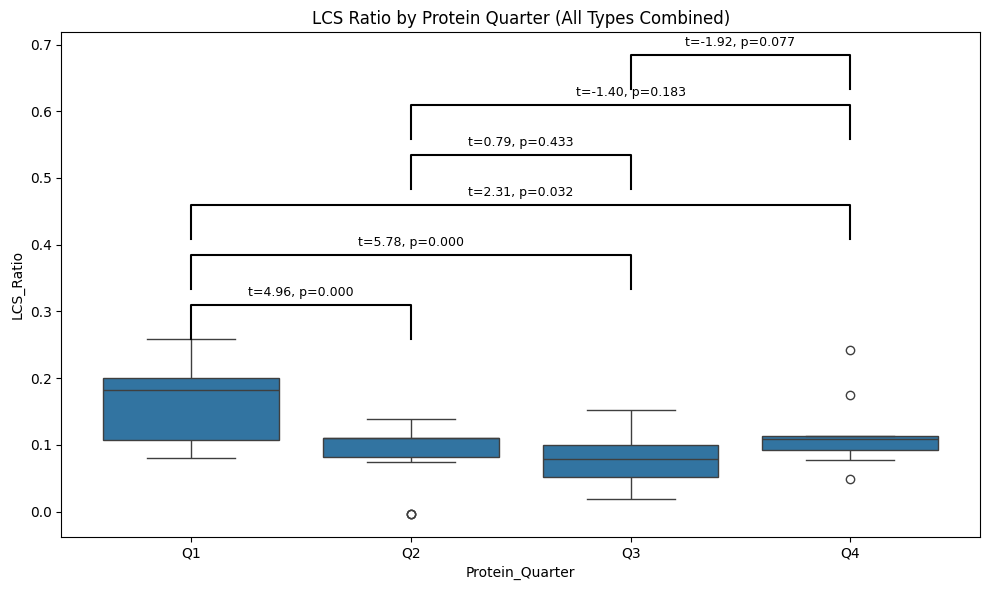

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
import os

# --- Path to your data file ---
lcs_csv_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Normalized Protein Positions\all_LCS_values.csv"
output_folder = os.path.dirname(lcs_csv_path)

# --- Load and clean data ---
df = pd.read_csv(lcs_csv_path)

# Exclude outlier heatmap positions
excluded_positions = [1, 2, 3, 13, 14, 15]
df_clean = df[~df['Heatmap_Position'].isin(excluded_positions)].copy()
df_clean['Heatmap_Position'] = pd.to_numeric(df_clean['Heatmap_Position'], errors='coerce')

# Normalize position and assign protein quarters
df_clean['Normalized_Position'] = (
    df_clean['Heatmap_Position'] - df_clean['Heatmap_Position'].min()
) / (df_clean['Heatmap_Position'].max() - df_clean['Heatmap_Position'].min())

df_clean['Protein_Quarter'] = pd.cut(
    df_clean['Normalized_Position'],
    bins=[0.0, 0.25, 0.5, 0.75, 1.0],
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    include_lowest=True
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_clean, x='Protein_Quarter', y='LCS_Ratio')
plt.title("LCS Ratio by Protein Quarter (All Types Combined)")

# Perform pairwise t-tests and annotate
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
pairs = list(itertools.combinations(quarters, 2))
y_max = df_clean['LCS_Ratio'].max()
y_offset = 0.05
spacing = y_offset * 1.5

for i, (q1, q2) in enumerate(pairs):
    data1 = df_clean[df_clean['Protein_Quarter'] == q1]['LCS_Ratio']
    data2 = df_clean[df_clean['Protein_Quarter'] == q2]['LCS_Ratio']
    if len(data1) > 1 and len(data2) > 1:
        t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
        x1, x2 = quarters.index(q1), quarters.index(q2)
        y = y_max + i * spacing
        ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], lw=1.5, color='black')
        ax.text((x1 + x2) / 2, y + y_offset + 0.01, f"t={t_stat:.2f}, p={p_val:.3f}",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save plot to output folder
plot_path = os.path.join(output_folder, "boxplot_by_quarter_pairwise_ttests.png")
plt.savefig(plot_path, dpi=300)
plt.show()
